In [1]:
import networkx as nx
from networkx.generators.classic import complete_graph
from math import floor, ceil
import numpy as np
from random import choices

class RandomGraph:
    
    def __init__(self, k):
        """
        creates an initial complete graph of size k+1
        """
        self.k = k
        self.graph = nx.complete_graph(k+1)
        
    def grow(self, n_iterations):
            
        for i in range(n_iterations):
            new_node = len(self.graph) # node numeration starts at 0
            nodes_link_added = set()
            n_edges_to_add = floor(self.k/2) if i % 2 == 0 else ceil(self.k/2)
            
            for _ in range(n_edges_to_add):
                distrib = np.array([d if n not in nodes_link_added else 0 for n,d in self.graph.degree])
                distrib = distrib / sum(distrib)
                node_to_link = choices(range(len(self.graph)), weights = distrib ,k=1)[0]
                nodes_link_added.add(node_to_link)
                    
                    
            self.graph.add_node(new_node)
            self.graph.add_edges_from([(new_node, node) for node in nodes_link_added])
        

In [2]:
from random import random, sample
from enum import Enum, auto

class State(Enum):
    # enum type for representing SIR states
    SUSCEPTIBLE = auto()
    INFECTED = auto()
    RECOVERED = auto()

N_NODES = 500
K = 6
BETA = 0.3
RHO = 0.7
N_WEEKS = 15
N = 100


In [3]:
g = RandomGraph(K)
g.grow(N_NODES-(K+1))

In [4]:
class Simulation:
    def __init__(self, network, initially_infected=None):
        self.network = network # should be RandomGraph underlying graph
        self.weeks = []
        self.weeks.append([State.SUSCEPTIBLE]*N_NODES)
        if initially_infected is None:
            initially_infected = sample(range(N_NODES), k=10)       
        for node in initially_infected:
            self.weeks[0][node] = State.INFECTED # self.weeks[0] represents initial state
            
    def simulate(self, n_weeks=N_WEEKS, beta=BETA, rho=RHO):
        for time in range(1,n_weeks+1):
            self.weeks.append([State.SUSCEPTIBLE]*N_NODES)
            for node in range(N_NODES):
                old_state = self.weeks[time-1][node]
                if old_state == State.SUSCEPTIBLE:
                    m = [self.weeks[time-1][neigh] for neigh in self.network.neighbors(node)].count(State.INFECTED)
                    new_state = State.INFECTED if random() < 1 - (1-beta)**m else State.SUSCEPTIBLE
                    self.weeks[time][node] = new_state
                elif old_state == State.INFECTED:
                    new_state = State.RECOVERED if random() < rho else State.INFECTED
                    self.weeks[time][node] = new_state
                else:
                    self.weeks[time][node] = State.RECOVERED

Text(0, 0.5, 'Number of newly infected nodes')

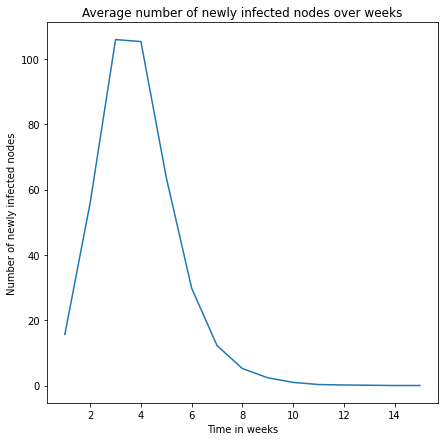

In [8]:
import matplotlib.pyplot as plt
infec = []

for _ in range(N):
    s = Simulation(g.graph)
    s.simulate()
    weeks = s.weeks
    infec.append([len([node for node in range(N_NODES) if weeks[time-1][node]==State.SUSCEPTIBLE and weeks[time][node]==State.INFECTED]) for time in range(1,len(weeks))])
    
infec = np.array(infec)

fig = plt.figure(1, figsize=(7,7))
ax = plt.subplot(111)

ax.plot(range(1,N_WEEKS+1), np.mean(infec, axis=0))

plt.title("Average number of newly infected nodes over weeks")
plt.xlabel("Time in weeks")
plt.ylabel("Number of newly infected nodes")

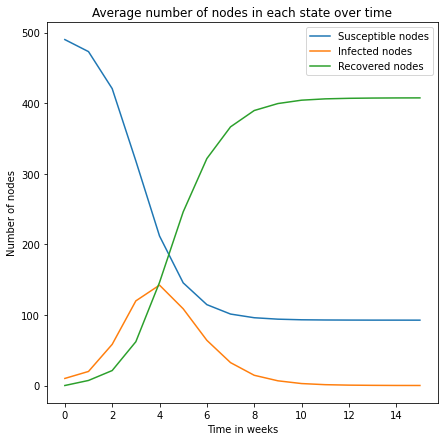

In [6]:
susc, infec, recov = [], [], []

for _ in range(N):
    s = Simulation(g.graph)
    s.simulate()
    weeks = s.weeks
    susc.append([weeks[time].count(State.SUSCEPTIBLE) for time in range(len(weeks))])
    infec.append([weeks[time].count(State.INFECTED) for time in range(len(weeks))])
    recov.append([weeks[time].count(State.RECOVERED) for time in range(len(weeks))])
    
susc, infec, recov = np.array(susc), np.array(infec), np.array(recov)

fig = plt.figure(1, figsize=(7,7))
ax = plt.subplot(111)
ax.plot(np.mean(susc, axis=0), label='Susceptible nodes')
ax.plot(np.mean(infec, axis=0), label='Infected nodes')
ax.plot(np.mean(recov, axis=0), label='Recovered nodes')
plt.title("Average number of nodes in each state over time")
plt.xlabel("Time in weeks")
plt.ylabel("Number of nodes")

ax.legend()